<a href="https://colab.research.google.com/github/lsmanoel/pythonLearningAndDeepLearning/blob/master/mask-rcnn/R_CNN_mask_openCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mask R-CNN and FAST R-CNN

This algorithm is a four-step process:

1.   Set input image 
2.   Extract ROIs (Region of Interest) from image using [Seletive Search](http://www.huppelen.nl/publications/selectiveSearchDraft.pdf)
3.   Compute CNN features of the ROIs defined by Seletive Search.
4.   Classify the ROIs

The original R-CNN architecture (source: [Girshick et al,. 2013](https://arxiv.org/abs/1311.2524)):

![alt text](https://www.pyimagesearch.com/wp-content/uploads/2018/11/mask_rcnn_rcn_orig.jpg)

The problem of the R-CNN method is its slow. To solve this, Fast R-CNN was created with a ROI Pooling module:

The Fast R-CNN architecture (source: [Girshick et al., 2015](https://arxiv.org/abs/1504.08083)).

![alt text](https://www.pyimagesearch.com/wp-content/uploads/2018/11/mask_rcnn_fast_rcnn.jpg)

[More About in pyimagesearch blog.](https://www.pyimagesearch.com/2018/11/19/mask-r-cnn-with-opencv/)

# Instance segmentation vs. Semantic segmentation:
![alt text](https://www.pyimagesearch.com/wp-content/uploads/2018/11/mask_rcnn_segmentation_types.jpg)
[source1](https://arxiv.org/abs/1704.06857)
[source2](https://www.pyimagesearch.com/2018/11/19/mask-r-cnn-with-opencv/)




---


To mount your google drive in colab Files workspace:





In [0]:
from google.colab import drive 
drive.mount('/content/gdrive')




---


To install the packages in colaboratory workspace:


In [0]:
!apt update
!apt install -y cmake
!pip install dlib



---


# The Code:
[Link to download all necessary files](https://drive.google.com/drive/folders/1NMNKvZ9FCoVdxghCsLxbHWVLSbNdg6LE?usp=sharing)

[INFO] Mask R-CNN took 4.529495 seconds
[INFO] boxes shape: (1, 1, 13, 7)
[INFO] masks shape: (100, 90, 15, 15)
Output:


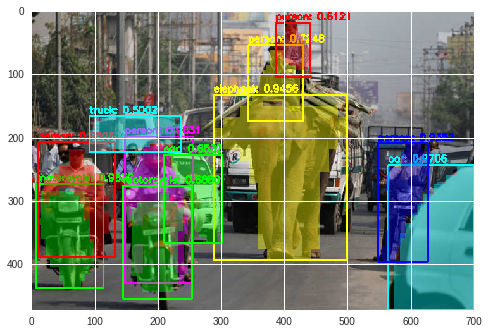

In [9]:
# import the necessary packages
import numpy as np
import random
import time
import cv2
import os
from matplotlib import pyplot as plt

# derive the paths to the Mask R-CNN weights and model configuration
weightsFolderPath = "gdrive/My Drive/Colab Notebooks/RNN/mask-rcnn-coco"
configFolderPath = "gdrive/My Drive/Colab Notebooks/RNN/mask-rcnn-coco"
labelsFolderPath = "gdrive/My Drive/Colab Notebooks/RNN/mask-rcnn-coco"
colorsFolderPath = "gdrive/My Drive/Colab Notebooks/RNN/mask-rcnn-coco"

weightsPath = os.path.sep.join([weightsFolderPath, "frozen_inference_graph.pb"])
configPath = os.path.sep.join([configFolderPath, "mask_rcnn_inception_v2_coco_2018_01_28.pbtxt"])
labelsPath = os.path.sep.join([labelsFolderPath, "object_detection_classes_coco.txt"])
colorsPath = os.path.sep.join([colorsFolderPath, "colors.txt"])

NET = cv2.dnn.readNetFromTensorflow(weightsPath, configPath)
LABELS = open(labelsPath).read().strip().split("\n")
COLORS = open(colorsPath).read().strip().split("\n")
COLORS = [np.array(c.split(",")).astype("int") for c in COLORS]
COLORS = np.array(COLORS, dtype="uint8")

# load our input image and grab its spatial dimensions
frameDatasetFolderPath = "gdrive/My Drive/Colab Notebooks/RNN/dataset_indiaChaos"
frameInputPath = os.path.sep.join([frameDatasetFolderPath, "example_04.jpg"])

frame = cv2.imread(frameInputPath)
(H, W) = frame.shape[:2]

# construct a blob from the input image and then perform a forward
# pass of the Mask R-CNN, giving us (1) the bounding box  coordinates
# of the objects in the image along with (2) the pixel-wise segmentation
# for each specific object
blob = cv2.dnn.blobFromImage(frame, swapRB=True, crop=False)

NET.setInput(blob)

#-------------------------------------------------------------------------------
# Start process detection:
start = time.time()
(boxes, masks) = NET.forward(["detection_out_final", "detection_masks"])
end = time.time()

# show timing information and volume information on Mask R-CNN
print("[INFO] Mask R-CNN took {:.6f} seconds".format(end - start))
print("[INFO] boxes shape: {}".format(boxes.shape))
print("[INFO] masks shape: {}".format(masks.shape))

#-------------------------------------------------------------------------------
confidenceThreshold = 0.5
binarizationThreshold = 0.3
visualize = 0

frameCopy = frame.copy()

# loop over the number of detected objects
for i in range(0, boxes.shape[2]):
    # extract the class ID of the detection along with the confidence
    # (i.e., probability) associated with the prediction
    classID = int(boxes[0, 0, i, 1])
    confidence = boxes[0, 0, i, 2]

    #---------------------------------------------------------------------------
    # filter out weak predictions by ensuring the detected probability
    # is greater than the minimum probability
    if confidence > confidenceThreshold:
        # clone our original image so we can draw on it


        # scale the bounding box coordinates back relative to the
        # size of the image and then compute the width and the height
        # of the bounding box
        box = boxes[0, 0, i, 3:7] * np.array([W, H, W, H])
        (startX, startY, endX, endY) = box.astype("int")
        boxW = endX - startX
        boxH = endY - startY

        # extract the pixel-wise segmentation for the object, resize
        # the mask such that it's the same dimensions of the bounding
        # box, and then finally threshold to create a *binary* mask
        mask = masks[i, classID]
        mask = cv2.resize(mask, (boxW, boxH), interpolation=cv2.INTER_NEAREST)
        mask = (mask > binarizationThreshold)

        # extract the ROI of the image
        frameRoi = frameCopy[startY:endY, startX:endX]

        #-----------------------------------------------------------------------
        # check to see if are going to visualize how to extract the
        # masked region itself
        if visualize > 0:
            # convert the mask from a boolean to an integer mask with
            # to values: 0 or 255, then apply the mask
            visMask = (mask * 255).astype("uint8")
            instance = cv2.bitwise_and(frameRoi, frameRoi, mask=visMask)

            # show the extracted ROI, the mask, along with the
            # segmented instance 
            frameRoi = cv2.cvtColor(frameRoi, cv2.COLOR_BGR2RGB)
#             visMask = cv2.cvtColor(visMask, cv2.COLOR_BGR2RGB)
            instance = cv2.cvtColor(instance, cv2.COLOR_BGR2RGB)
            
            print("ROI:")
            plt.imshow(frameRoi)
            plt.show()
            
            print("Mask:")
            plt.imshow(visMask)
            plt.show()
            
            print("Segmented:")
            plt.imshow(instance)
            plt.show()
            

        #-----------------------------------------------------------------------
        # now, extract *only* the masked region of the ROI by passing
        # in the boolean mask array as our slice condition
        frameRoi = frameRoi[mask]

        # randomly select a color that will be used to visualize this
        # particular instance segmentation then create a transparent
        # overlay by blending the randomly selected color with the ROI
        color = random.choice(COLORS)
        blended = ((0.4 * color) + (0.6 * frameRoi)).astype("uint8")

        # store the blended ROI in the original image
        frameCopy[startY:endY, startX:endX][mask] = blended

        # draw the bounding box of the instance on the image
        color = [int(c) for c in color]
        cv2.rectangle(frameCopy, (startX, startY), (endX, endY), color, 2)

        # draw the predicted label and associated probability of the
        # instance segmentation on the image
        text = "{}: {:.4f}".format(LABELS[classID], confidence)
        cv2.putText(frameCopy, text, (startX, startY - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# show the output image
frameCopy = cv2.cvtColor(frameCopy, cv2.COLOR_BGR2RGB)
print("Output:")
plt.imshow(frameCopy)
plt.show()


# Reference and Documentation:

[PyImageSearch Blog](https://www.pyimagesearch.com/2018/11/19/mask-r-cnn-with-opencv/)

[lOpenCV DNN documentation](https://docs.opencv.org/3.4/d6/d0f/group__dnn.html#ga29f34df9376379a603acd8df581ac8d7)

[Fast R-CNN](https://arxiv.org/abs/1504.08083)